In [2]:
%pip install transformers datasets evaluate -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 10.7 MB/s eta 0:00:00


In [5]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
from evaluate import load

perplexity = load("perplexity", module_type="metric")

In [12]:
input_texts = ["a house in the forest", "a house on the sun", "a house in hell"]
results = perplexity.compute(model_id='gpt2',
                             add_start_token=False,
                             predictions=input_texts, device=device)

Using pad_token, but it is not set yet.


  0%|          | 0/1 [00:00<?, ?it/s]

In [13]:
results

{'perplexities': [142.99826049804688, 415.82159423828125, 1144.3707275390625],
 'mean_perplexity': 567.7301940917969}

In [3]:
from transformers import GPT2LMHeadModel, GPT2TokenizerFast

model_id = "gpt2-large"
model = GPT2LMHeadModel.from_pretrained(model_id).to(device)
tokenizer = GPT2TokenizerFast.from_pretrained(model_id)


In [4]:
from datasets import load_dataset

ds = load_dataset('martingrzzler/mnemonics_benchmark')

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/martingrzzler___json/martingrzzler--mnemonics_benchmark-6cc75b71b93e3c15/0.0.0/fe5dd6ea2639a6df622901539cb550cf8797e5a6b2dd7af1cf934bed8e233e6e. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [5]:
low_test = 'I went to the bathroom and took a shower'
high_test = 'Gibber doesnt make no lo sense what que suss'

In [6]:
encodings = tokenizer([high_test], return_tensors='pt')

In [7]:
encodings

{'input_ids': tensor([[   38,   571,   527, 46701,   787,   645,  2376,  2565,   644,  8358,
           264,  1046]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [8]:
encodings.input_ids.size(1)

12

In [9]:
encodings = ds['train'][34]['gpt2xl_mnemonic']
encodings = tokenizer([encodings], return_tensors='pt')
encodings.input_ids.size(1)

69

In [10]:
import re
def clean(text):
    return re.sub('<.*?>', '', text)

In [11]:

print(clean(ds['train'][34]['wanikani_mnemonic']))

A leader puts their hat on the ground next to a bookshelf. This is a test in ethics. People hang around the bookshelf, and the leader wants to see if anyone will steal the hat or not. That's why its a test of ethics.


In [12]:
def ppl(text):
    encodings = tokenizer([text], return_tensors='pt')
    seq_len = encodings.input_ids.size(1)
    stride = 512
    nlls = []
    prev_end_loc = 0

    for begin_loc in range(0, seq_len, stride):
        end_loc = min(begin_loc + stride, seq_len)
        trg_len = end_loc - prev_end_loc
        input_ids = encodings.input_ids[:, prev_end_loc:end_loc].to(device)
        target_ids = input_ids.clone()
        target_ids[:, :-trg_len] = -100

        with torch.no_grad():
            outputs = model(input_ids, labels=target_ids)
            neg_log_likelihood = outputs.loss * trg_len

        nlls.append(neg_log_likelihood)

        prev_end_loc = end_loc
        if end_loc == seq_len:
            break

    ppl = torch.exp(torch.stack(nlls).sum() / end_loc)
    return ppl

In [13]:
def map_ppl(example):
    example['gpt3_paragraph_ppl'] = ppl(example['gpt3_paragraph'])
    example['gpt3_mnemonic_ppl'] = ppl(example['gpt3_mnemonic'])
    example['wanikani_mnemonic_ppl'] = ppl(clean(example['wanikani_mnemonic']))
    example['gpt2xl_mnemonic_ppl'] = ppl(example['gpt2xl_mnemonic'])

    return example

In [14]:
ds_ppl = ds.map(map_ppl)

Map:   0%|          | 0/190 [00:00<?, ? examples/s]

In [15]:
ds_ppl

DatasetDict({
    train: Dataset({
        features: ['kanji_id', 'component_meanings', 'wanikani_mnemonic', 'kanji_meaning', 'gpt2xl_mnemonic', 'gpt3_paragraph', 'gpt3_mnemonic', 'gpt3_paragraph_ppl', 'gpt3_mnemonic_ppl', 'wanikani_mnemonic_ppl', 'gpt2xl_mnemonic_ppl'],
        num_rows: 190
    })
})

In [16]:
from scipy.stats import f_oneway
def anova(ds):
    f, p = f_oneway(ds['gpt3_paragraph_ppl'],  ds['gpt3_mnemonic_ppl'], ds['wanikani_mnemonic_ppl'], ds['gpt2xl_mnemonic_ppl'])
    return p

In [17]:
anova(ds_ppl['train'])

1.0640174850603205e-66

In [18]:
import matplotlib.pyplot as plt


def box_plot(df, title):
    fig, ax = plt.subplots(1,1)
    ax.boxplot([df['gpt3_paragraph_ppl'], df['gpt3_mnemonic_ppl'], df['wanikani_mnemonic_ppl'], df['gpt2xl_mnemonic_ppl']], showfliers=False)

    ax.set_xticklabels(['GPT-3 Paragraph', 'GPT-3 Mnemonic', 'WaniKani', 'GPT-2XL'])
    ax.set_title(title)
    plt.show()

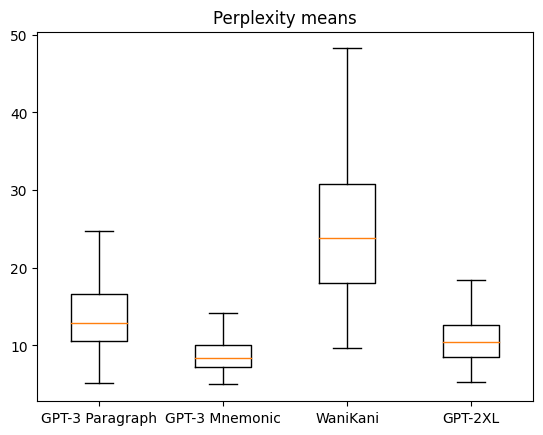

In [20]:
box_plot(ds_ppl['train'], 'Perplexity means')

In [5]:
# let's try gpt neo
from transformers import GPTNeoForCausalLM, GPT2TokenizerFast

model = GPTNeoForCausalLM.from_pretrained("EleutherAI/gpt-neo-1.3B")
tokenizer = GPT2TokenizerFast.from_pretrained("EleutherAI/gpt-neo-1.3B")

model = model.to(device)

In [21]:
print(anova(ds_ppl['train']))

4.227575349662175e-53


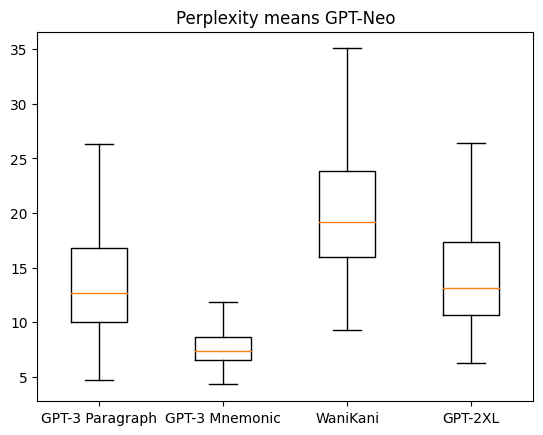

In [22]:
box_plot(ds_ppl['train'], 'Perplexity means GPT-Neo')